In [ ]:
#| hide
#| eval: false
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

# Custom transforms

> Using `Datasets`, `Pipeline`, `TfmdLists` and `Transform` in computer vision

## Overview

In [ ]:
from fastai.vision.all import *

### Creating your own `Transform`

Creating your own `Transform` is way easier than you think. In fact, each time you have passed a label function to the data block API or to `ImageDataLoaders.from_name_func`, you have created a `Transform` without knowing it. At its base, a `Transform` is just a function. Let's show how you can easily add a transform by implementing one that wraps a data augmentation from the [albumentations library](https://github.com/albumentations-team/albumentations).

First things first, you will need to install the albumentations library. Uncomment the following cell to do so if needed:

In [ ]:
# !pip install albumentations

Then it's going to be easier to see the result of the transform on a color image bigger than the mnist one we had before, so let's load something from the PETS dataset.

In [ ]:
source = untar_data(URLs.PETS)
items = get_image_files(source/"images")

We can still open it with `PILIlmage.create`:

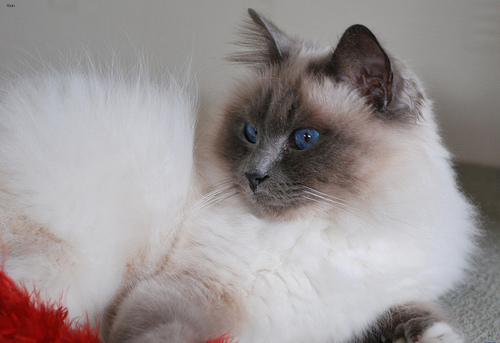

In [ ]:
img = PILImage.create(items[0])
img

We will show how to wrap one transform, but you can as easily wrap any set of transforms you wrapped in a `Compose` method. Here let's do some `ShiftScaleRotate`:

In [ ]:
from albumentations import ShiftScaleRotate

The albumentations transform work on numpy images, so we just convert our `PILImage` to a numpy array before wrapping it back in `PILImage.create` (this function takes filenames as well as arrays or tensors).

In [ ]:
aug = ShiftScaleRotate(p=1)
def aug_tfm(img): 
    np_img = np.array(img)
    aug_img = aug(image=np_img)['image']
    return PILImage.create(aug_img)

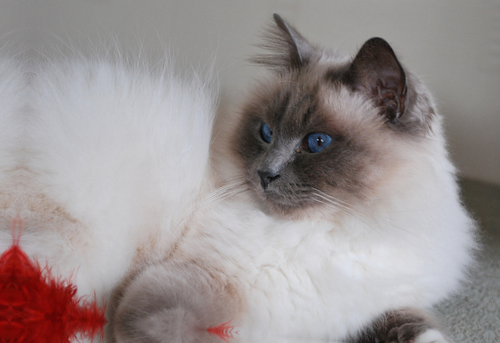

In [ ]:
aug_tfm(img)

We can pass this function each time a `Transform` is expected and the fastai library will automatically do the conversion. That's because you can directly pass such a function to create a `Transform`:

In [ ]:
tfm = Transform(aug_tfm)

If you have some state in your transform, you might want to create a subclass of `Transform`. In that case, the function you want to apply should be written in the <code>encodes</code> method (the same way you implement `forward` for PyTorch module):

In [ ]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

We also added a type annotation: this will make sure this transform is only applied to `PILImage`s and their subclasses. For any other object, it won't do anything. You can also write as many <code>encodes</code> method you want with different type-annotations and the `Transform` will properly dispatch the objects it receives.

This is because in practice, the transform is often applied as an `item_tfms` (or a `batch_tfms`) that you pass in the data block API. Those items are a tuple of objects of different types, and the transform may have different behaviors on each part of the tuple.

Let's check here how this works:

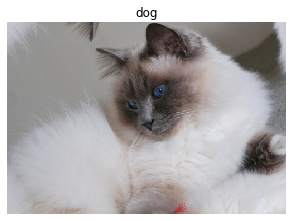

In [ ]:
tfm = AlbumentationsTransform(ShiftScaleRotate(p=1))
a,b = tfm((img, 'dog'))
show_image(a, title=b);

The transform was applied over the tuple `(img, "dog")`. `img` is a `PILImage`, so it applied the <code>encodes</code> method we wrote. `"dog"` is a string, so the transform did nothing to it. 

Sometimes however, you need your transform to take your tuple as whole: for instance albumentations is applied simultaneously on images and segmentation masks. In this case you need to subclass `ItemTransfrom` instead of `Transform`. Let's see how this works:

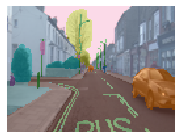

In [ ]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
img = PILImage.create(cv_items[0])
mask = PILMask.create(cv_source/'labels'/f'{cv_items[0].stem}_P{cv_items[0].suffix}')
ax = img.show()
ax = mask.show(ctx=ax)

We then write a subclass of `ItemTransform` that can wrap any albumentations augmentation transform, but only for a segmentation problem:

In [ ]:
class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

And we can check how it gets applied on the tuple `(img, mask)`. This means you can pass it as an `item_tfms` in any segmentation problem.

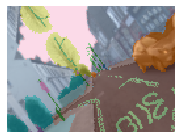

In [ ]:
tfm = SegmentationAlbumentationsTransform(ShiftScaleRotate(p=1))
a,b = tfm((img, mask))
ax = a.show()
ax = b.show(ctx=ax)

### Segmentation

By using the same transforms in `after_item` but a different kind of targets (here segmentation masks), the targets are automatically processed as they should with the type-dispatch system.

In [ ]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
cv_splitter = RandomSplitter(seed=42)
cv_split = cv_splitter(cv_items)
cv_label = lambda o: cv_source/'labels'/f'{o.stem}_P{o.suffix}'

In [ ]:
class ImageResizer(Transform):
    order=1
    "Resize image to `size` using `resample`"
    def __init__(self, size, resample=BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample

    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)
    def encodes(self, o:PILMask):  return o.resize(size=self.size, resample=NEAREST)

In [ ]:
tfms = [[PILImage.create], [cv_label, PILMask.create]]
cv_dsets = Datasets(cv_items, tfms, splits=cv_split)
dls = cv_dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

If we want to use the augmentation transform we created before, we just need to add one thing to it: we want it to be applied on the training set only, not the validation set. To do this, we specify it should only be applied on a specific `idx` of our splits by adding `split_idx=0` (0 is for the training set, 1 for the validation set):

In [ ]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

And we can check how it gets applied on the tuple `(img, mask)`. This means you can pass it as an `item_tfms` in any segmentation problem.

In [ ]:
cv_dsets = Datasets(cv_items, tfms, splits=cv_split)
dls = cv_dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor(), 
                                              SegmentationAlbumentationsTransform(ShiftScaleRotate(p=1))])

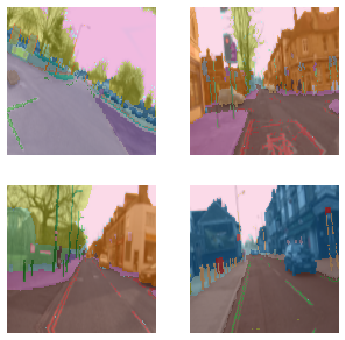

In [ ]:
dls.show_batch(max_n=4)

### Using different transform pipelines and the `DataBlock API`

It's very common for us to use different transforms on the training dataset versus the validation dataset. Currently our `AlbumentationsTransform` will perform the same transform over both, let's see if we can make it a bit more flexible with what we want. 

Let's try to think of a scenario for our examle:

I want to various data augmentations such as `HueSaturationValue` or `Flip` to operate similar to how fastai will do it, where they only run on the training dataset but not the validation dataset. What do we need to do to our `AlbumentationsTransform`?

In [ ]:
class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()
    
    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

Here is our newly written transform. But what changed?

We added in a `split_idx`, which is what determines what transforms are run on the validation set and the training set (0 for train, 1 for validation, `None` for both).

Along with this we set an `order` to `2`. What this entails is if we have any fastai transforms that perform a resize operation, those are done first before our new transform. This let's us know exactly when our transform is going to be applied, and how we can work with it!

Let's look at an example with some `Composed` albumentations transforms:

In [ ]:
import albumentations

In [ ]:
def get_train_aug(): return albumentations.Compose([
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

We can define our `ItemTransforms` with `Resize` and our new training augmentations:

In [ ]:
item_tfms = [Resize(224), AlbumentationsTransform(get_train_aug())]

Let's use the higher-level `DataBlock` API this time:

In [ ]:
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=item_tfms)

And take a peek at some data:

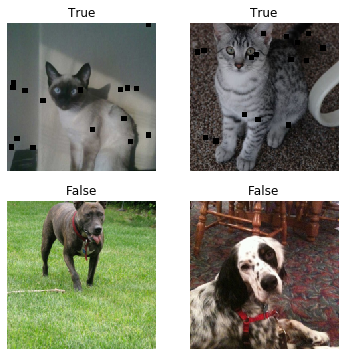

In [ ]:
dls.train.show_batch(max_n=4)

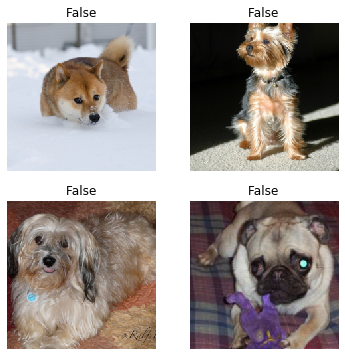

In [ ]:
dls.valid.show_batch(max_n=4)

We can see that our transforms were successfully only applied to our training data! Great!

Now, what if we wanted special different behaviors applied to **both** the training and validation sets? Let's see:

In [ ]:
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

So let's walk through what's happening here. We changed our `split_idx` to be `None`, which allows for us to say when we're setting our `split_idx`.

We also inherit from `RandTransform`, which allows for us to set that `split_idx` in our `before_call`. 

Finally we check to see what the current `split_idx` *is*. If it's `0`, run the trainining augmentation, otherwise run the validation augmentation. 

Let's see an example of a typical training setup:

In [ ]:
def get_train_aug(): return albumentations.Compose([
            albumentations.RandomResizedCrop(224,224),
            albumentations.Transpose(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

def get_valid_aug(): return albumentations.Compose([
    albumentations.CenterCrop(224,224, p=1.),
    albumentations.Resize(224,224)
], p=1.)

Next we'll build our new `AlbumentationsTransform`:

In [ ]:
item_tfms = [Resize(256), AlbumentationsTransform(get_train_aug(), get_valid_aug())]

And pass this into our `DataLoaders`:
> Since we declared a resize already in our composed transforms, we do not need any item transforms present here

In [ ]:
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=item_tfms)

We can compare our training and validation augmentation again to find that they are indeed different:

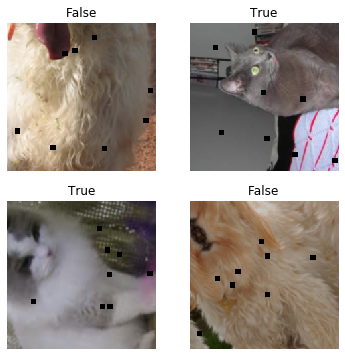

In [ ]:
dls.train.show_batch(max_n=4)

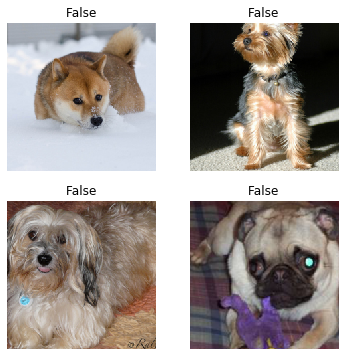

In [ ]:
dls.valid.show_batch(max_n=4)

And looking at the shapes of the validation `DataLoader`'s `x`'s we'll find our `CenterCrop` was applied as well:

In [ ]:
x,_ = dls.valid.one_batch()
print(x.shape)

(64, 3, 224, 224)


:::{.callout-note}

We used fastai's crop first as some padding is needed due to some image sizes being too small.

:::

## fin -